#Macro Event based Stock Market Prediction
The problem statement aims to predict the stock price of Dow Jones Industrial Average as a Proof of Concept.

Macro Events taken into considerations are
- Social media
 - Reddit
- Natural Calamities
 - Wildfire
 - Hurricane
 - Flood
 - Blizzard
 - Snowstorm
 - Tornado
- Pandemic
 - Covid
- Inflation Rate

Since social media dataset would be in the form of posts, of which top 25 'hot' posts are considered, their impact prediction along with other macro events would help us better predict stock price fluctuation, targetting to predict the impact before it becomes widely available on news sites.

Prediction model is split into 2 parts:
1.	Sentiment Impact Analysis: Prediction of the type of impact of Reddit posts on Adj Close price.
2.	Regression Prediction: using the sentiment impact prediction and other macro-event capturing features to predict the Adj Close price.


#Mounting Google Drive
- to get access to the source data files
- to save model and plot pngs

In [1]:
# Mount google drive to get access to the source files
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Loading all libraries

In [2]:
!pip install bayesian-optimization

In [3]:
# import libraries and set home directory

import collections as col
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import tensorflow as tf

from bayes_opt import BayesianOptimization
from bs4 import BeautifulSoup
from functools import partial
from keras.models import model_from_json
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, auc, classification_report
from sklearn.metrics import confusion_matrix, f1_score, roc_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBClassifier

plt.style.use('seaborn-dark-palette')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Download required sets

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# defining paths

home = "/content/gdrive/My Drive/Colab Notebooks/stock_market/"

# data source files
sentiment_data_filename = home + "Combined_News_DJIA.csv"
stock_market_data_filename = home + "upload_DJIA_table.csv"
stock_market_macro_filename = home + "upload_DJIA_table_updated.csv"

# predicted sentiment impact
predicted_sentiment_impact_filename = home + "Predicted_Sentiment_Impact.csv"

# lstm trained model
model_path = home + 'lstm_model.json'

# Predicted Vs actual stock plot
stock_prediction_plot_path = home + 'PredictedVsActualPlot.jpg'

#Sentiment Impact Prediction

##Data Preprocessing

In [6]:
# Gathering dataset

sentiment_data = pd.read_csv(sentiment_data_filename)
djia_data = pd.read_csv(stock_market_data_filename)

In [7]:
# Data Clean-up

# removing all NaN and null values
print("NaN values prior to clean up :",sentiment_data.isna().sum().sum())
sentiment_data['Top23'].fillna("UNKNOWN", inplace=True)
sentiment_data['Top24'].fillna("UNKNOWN",inplace=True)
sentiment_data['Top25'].fillna("UNKNOWN",inplace=True)
print("NaN values after clean up :",sentiment_data.isna().sum().sum())

NaN values prior to clean up : 7
NaN values after clean up : 0


In [8]:
# Data Preperation

data_merged = djia_data.merge(sentiment_data, on='Date')

data_merged['Open_shift'] = data_merged['Open'].shift(1)
data_merged = data_merged.dropna()

# data_merged['Label_adj'] = (data_merged['Open_shift'] >= data_merged['Open']).astype('int')
data_merged['Label_adj'] = data_merged['Label']

data_merged = data_merged.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Label', 'Open_shift'], axis=1)

sentiment_train = data_merged[(data_merged['Date'] < '2015-01-01')]
sentiment_test = data_merged[(data_merged['Date'] > '2014-12-31')]

## Exploratory Data Analysis

In [9]:
# Checking the shape of the data

print("shape of dataset :",data_merged.shape)

shape of dataset : (1988, 27)


In [10]:
# Checking the columns and data types

data_merged.dtypes

Date         object
Top1         object
Top2         object
Top3         object
Top4         object
Top5         object
Top6         object
Top7         object
Top8         object
Top9         object
Top10        object
Top11        object
Top12        object
Top13        object
Top14        object
Top15        object
Top16        object
Top17        object
Top18        object
Top19        object
Top20        object
Top21        object
Top22        object
Top23        object
Top24        object
Top25        object
Label_adj     int64
dtype: object

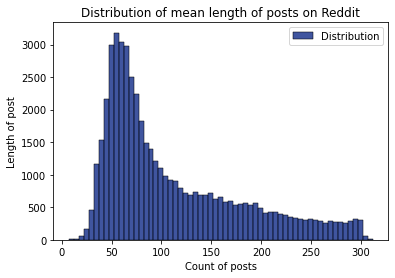

In [11]:
# Mean length of posts on Reddit

mean_len = []
for sentiment_data_index in range(len(data_merged)):
    posts = data_merged.loc[:, 'Top1':'Top25'].iloc[sentiment_data_index]
    for each_post in posts:
        mean_len.append(np.mean(len( each_post )))
    
ax = sns.histplot(mean_len, kde=False, label='Distribution')
ax.set(xlabel='Count of posts', ylabel='Length of post')
plt.title('Distribution of mean length of posts on Reddit')
ax.legend()
plt.show()

Ratio of 1:0 label values in Train set:  1.1829268292682926
Ratio of 1:0 label values in Test set:  1.0268817204301075


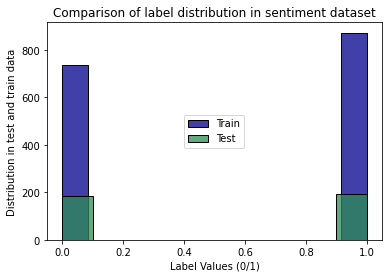

In [12]:
# Compare ratio of labels in test and train dataset for equal distribution

train_ratio = len(sentiment_train[sentiment_train['Label_adj'] == 1])/len(sentiment_train[sentiment_train['Label_adj'] == 0])
test_ratio = len(sentiment_test[sentiment_test['Label_adj'] == 1])/len(sentiment_test[sentiment_test['Label_adj'] == 0])
print("Ratio of 1:0 label values in Train set: ", train_ratio)
print("Ratio of 1:0 label values in Test set: ", test_ratio)

# Plot the distribution of labels in sentiment dataset
ax = sns.histplot(sentiment_train['Label_adj'], color='darkblue', label="Train")
ax = sns.histplot(sentiment_test['Label_adj'], color='seagreen', label="Test")
ax.set(xlabel='Label Values (0/1)', ylabel='Distribution in test and train data')
plt.title('Comparison of label distribution in sentiment dataset')
ax.legend(loc='center')
plt.show()

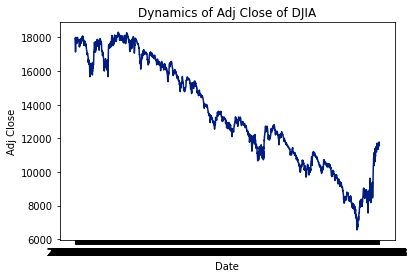

In [13]:
# DJIA adjacent close data trend

plt.plot(djia_data['Date'], djia_data['Adj Close'])
plt.title('Dynamics of Adj Close of DJIA')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

Analysing decomposed time series


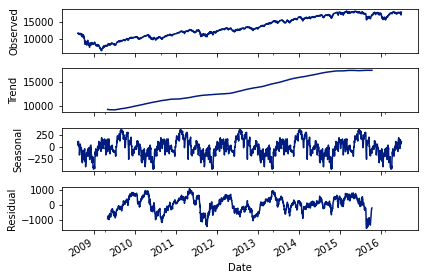

In [14]:
# Decomposing the dataset to check its trend, seasonality and residual over a annual freq

print('Analysing decomposed time series')
djia_data.reset_index(inplace=True)
djia_data['Date'] = pd.to_datetime(djia_data['Date'])
djia_data = djia_data.set_index('Date')
result = seasonal_decompose(djia_data['Adj Close'], model='additive', freq=365)
result.plot()
plt.show()

## Feature Engineering

In [15]:
# Clean and transform test before training the model

contractions = { 
"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not", 
"couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have","hasn't": "has not",
"haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will", "he's": "he is", "how'd": "how did", "how'll": "how will", "how's": "how is",
"i'd": "i would", "i'll": "i will", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'll": "it will", "it's": "it is", "let's": "let us",
"ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "must've": "must have", "mustn't": "must not", "needn't": "need not",
"oughtn't": "ought not", "shan't": "shall not", "sha'n't": "shall not", "she'd": "she would", "she'll": "she will", "she's": "she is", "should've": "should have",
"shouldn't": "should not", "that'd": "that would", "that's": "that is", "there'd": "there had", "there's": "there is", "they'd": "they would", "they'll": "they will",
"they're": "they are", "they've": "they have", "wasn't": "was not", "we'd": "we would", "we'll": "we will", "we're": "we are", "we've": "we have","weren't": "were not",
"what'll": "what will", "what're": "what are", "what's": "what is", "what've": "what have", "where'd": "where did", "where's": "where is", "who'll": "who will",
"who's": "who is", "won't": "will not", "wouldn't": "would not", "you'd": "you would", "you'll": "you will","you're": "you are"
}

def clean_text(text, remove_stopwords = True):
    
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
    return text

english_stemmer=nltk.stem.SnowballStemmer('english')

trainheadlines = []
for row in range(0,len(sentiment_train.index)):
    trainheadlines.append(clean_text(' '.join(str(x) for x in sentiment_train.iloc[row,1:26])))
    
testheadlines = []
for row in range(0,len(sentiment_test.index)):
    testheadlines.append(clean_text(' '.join(str(x) for x in sentiment_test.iloc[row,2:27])))

In [16]:
tokens_all = []
for headlines in trainheadlines:
    tokens = nltk.word_tokenize(headlines)
    tokens_all += tokens
    
counter_train = col.Counter(tokens_all)

tokens_all = []
for headlines in testheadlines:
    tokens = nltk.word_tokenize(headlines)
    tokens_all += tokens
    
counter_test = col.Counter(tokens_all)

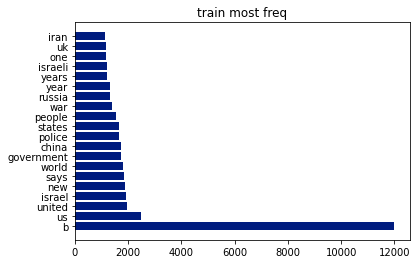

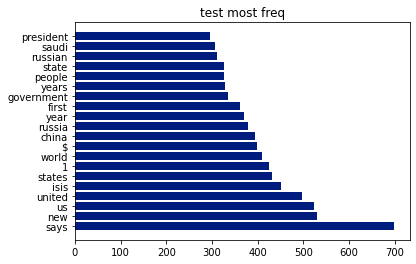

In [17]:
c_train = np.array(counter_train.most_common(20))
c_test = np.array(counter_test.most_common(20))

plt.barh(c_train[:, 0], c_train[:, 1].astype('int'))
plt.title("train most freq")
plt.show()
plt.barh(c_test[:, 0], c_test[:, 1].astype('int'))
plt.title("test most freq")
plt.show()

In [18]:
# Convert a collection of text documents to a matrix of token counts

basicvectorizer = CountVectorizer()
sentiment_x_train = basicvectorizer.fit_transform(trainheadlines)
sentiment_x_test = basicvectorizer.transform(testheadlines)

sentiment_y_train = sentiment_train['Label_adj']
sentiment_y_test = sentiment_test['Label_adj']

# checking the shapes
print("Shape of x_train :", sentiment_x_train.shape)
print("Shape of y_train :", sentiment_y_train.shape)
print("Shape of x_test :", sentiment_x_test.shape)
print("Shape of y_test :", sentiment_y_test.shape)

Shape of x_train : (1611, 31613)
Shape of y_train : (1611,)
Shape of x_test : (377, 31613)
Shape of y_test : (377,)


## Model Training

In [19]:
#  Model Evaluation

accuracies={}
aucList={}
accuracies_f1={}

def get_score(model, x_train, x_test, y_train, y_test, y_pred):
    # evaluating the model
    print('\n#################### Score ####################\n')
    train_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)
    f1_scr = f1_score(y_test, y_pred)
    print("Training Accuracy (Score) : ", train_score)
    print("Testing Accuracy (Score) : ", test_score)
    print("F1 Score : ", f1_scr)
    return train_score, test_score, f1_scr;
    
def get_auc(plt, model, x_test, y_test):
    y_pred_quant = model.predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)
    auc_value = auc(fpr, tpr)
    print('\n Area Under the Curve : ',auc_value)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve ')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    plt.show() 
    return auc_value;


def get_model_evaluate(model, x_train, x_test, y_train, y_test, y_pred):
    print('Model Evaluation')
    train_score, test_score, f1_scr = get_score(model, x_train, x_test, y_train, y_test, y_pred)
    
    # Classification report
    print('\n################### Classification Matrix ###############\n')
    cr = classification_report(y_test, y_pred)
    print(cr)

    # Confustion matrix
    print('\n################### Confusion Matrix ##################\n')
    cm = confusion_matrix(y_test, y_pred)
    total=sum(sum(cm))    
    accuracy=(cm[0,0]+cm[1,1])/total
    print ('Accuracy : ', accuracy)
    sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
    print('Sensitivity : ', sensitivity )
    specificity = cm[1,1]/(cm[1,0]+cm[1,1])
    print('Specificity : ', specificity)
    plt.rcParams['figure.figsize'] = (6, 6)
    sns.heatmap(cm ,annot = True, fmt=".1f") 
    plt.show()   
   
    return;

Model Evaluation

#################### Score ####################

Training Accuracy (Score) :  0.6219739292364991
Testing Accuracy (Score) :  0.4907161803713528
F1 Score :  0.6349809885931559

################### Classification Matrix ###############

              precision    recall  f1-score   support

           0       0.43      0.10      0.16       186
           1       0.50      0.87      0.63       191

    accuracy                           0.49       377
   macro avg       0.46      0.49      0.40       377
weighted avg       0.46      0.49      0.40       377


################### Confusion Matrix ##################

Accuracy :  0.4907161803713528
Sensitivity :  0.0967741935483871
Specificity :  0.8743455497382199


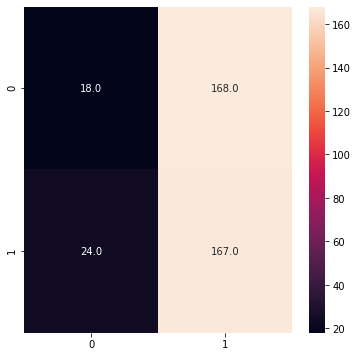

In [20]:
# Random Forest

RFmodel = RandomForestClassifier(n_estimators=10, criterion="entropy", max_features="sqrt", bootstrap=True, max_depth=6)

RFmodel.fit(sentiment_x_train,sentiment_y_train)
sentiment_y_pred_rf = RFmodel.predict(sentiment_x_test)

get_model_evaluate(RFmodel, sentiment_x_train, sentiment_x_test, sentiment_y_train, sentiment_y_test, sentiment_y_pred_rf)


Model Evaluation

#################### Score ####################

Training Accuracy (Score) :  0.7529484792054625
Testing Accuracy (Score) :  0.5225464190981433
F1 Score :  0.6616541353383457

################### Classification Matrix ###############

              precision    recall  f1-score   support

           0       0.58      0.11      0.19       186
           1       0.52      0.92      0.66       191

    accuracy                           0.52       377
   macro avg       0.55      0.52      0.43       377
weighted avg       0.55      0.52      0.43       377


################### Confusion Matrix ##################

Accuracy :  0.5225464190981433
Sensitivity :  0.11290322580645161
Specificity :  0.9214659685863874


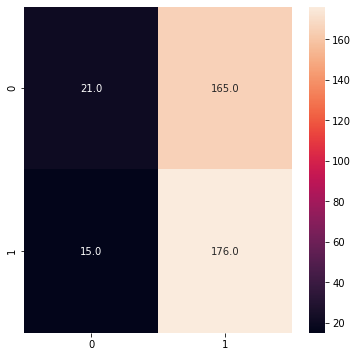

In [21]:
# XGB classification model

XGBmodel = XGBClassifier(max_depth=11, gamma=9.777, min_child_weight=0.3297, max_delta_step=8.968, subsample=0.8236, colsample_bytree=0.5187, learning_rate=0.01, eval_matrix='auc')  

training = XGBmodel.fit(sentiment_x_train, sentiment_y_train)
sentiment_y_pred_xgb = XGBmodel.predict(sentiment_x_test)

#Model Evaluation
get_model_evaluate(XGBmodel, sentiment_x_train, sentiment_x_test, sentiment_y_train, sentiment_y_test, sentiment_y_pred_xgb)

Model Evaluation

#################### Score ####################

Training Accuracy (Score) :  0.5046554934823091
Testing Accuracy (Score) :  0.5172413793103449
F1 Score :  0.6345381526104418

################### Classification Matrix ###############

              precision    recall  f1-score   support

           0       0.53      0.20      0.29       186
           1       0.51      0.83      0.63       191

    accuracy                           0.52       377
   macro avg       0.52      0.51      0.46       377
weighted avg       0.52      0.52      0.46       377


################### Confusion Matrix ##################

Accuracy :  0.5172413793103449
Sensitivity :  0.1989247311827957
Specificity :  0.8272251308900523


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


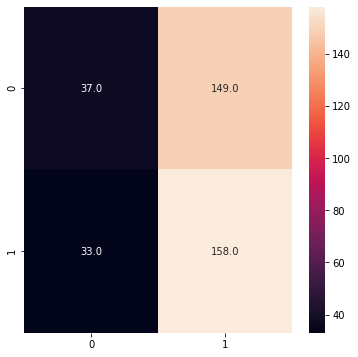

In [22]:
# SGD classifier

SGDmodel = SGDClassifier(early_stopping=True, n_iter_no_change=300, tol=0.1, max_iter=170, learning_rate='adaptive', eta0=2, validation_fraction=0.2, loss='squared_epsilon_insensitive')

SGDmodel = SGDmodel.fit(sentiment_x_train,sentiment_y_train)
sentiment_y_pred_sgd = SGDmodel.predict(sentiment_x_test)

get_model_evaluate(SGDmodel, sentiment_x_train, sentiment_x_test, sentiment_y_train, sentiment_y_test, sentiment_y_pred_sgd)


In [23]:
# Voting classifier Bay
def hybridfit_with(x_train, y_train, x_test, y_test, rf_w, xgb_w, sgd_w):
    eclf = VotingClassifier(estimators=[('rf', RFmodel), ('xgb', XGBmodel), ('sgd', SGDmodel)], voting='hard', 
                            weights=[rf_w, xgb_w, sgd_w])
    eclf = eclf.fit(x_train, y_train)
    y_pred = eclf.predict(x_test)
    return f1_score(y_test, y_pred)

verbose = 1
hybridfit_with_partial = partial(hybridfit_with, sentiment_x_train, sentiment_y_train, sentiment_x_test, sentiment_y_test)

# Bounded region of parameter space
pbounds = {
    "rf_w": (10,20), 
    "xgb_w": (30,40), 
    "sgd_w": (2,4)
}

optimizer = BayesianOptimization(
    f=hybridfit_with_partial,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(init_points=3, n_iter=4,)
optimizer.max['params']


|   iter    |  target   |   rf_w    |   sgd_w   |   xgb_w   |
-------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  1        |  0.6617   |  14.17    |  3.441    |  30.0     |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  2        |  0.6617   |  13.02    |  2.294    |  30.92    |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  3        |  0.6617   |  11.86    |  2.691    |  33.97    |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  4        |  0.6617   |  19.92    |  2.328    |  39.99    |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  5        |  0.6617   |  19.98    |  2.899    |  39.93    |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


|  6        |  0.6617   |  10.19    |  3.891    |  39.97    |
|  7        |  0.6617   |  19.99    |  2.061    |  30.0     |


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


{'rf_w': 14.17022004702574,
 'sgd_w': 3.440648986884316,
 'xgb_w': 30.001143748173448}

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Model Evaluation

#################### Score ####################

Training Accuracy (Score) :  0.7529484792054625
Testing Accuracy (Score) :  0.5225464190981433
F1 Score :  0.6616541353383457

################### Classification Matrix ###############

              precision    recall  f1-score   support

           0       0.58      0.11      0.19       186
           1       0.52      0.92      0.66       191

    accuracy                           0.52       377
   macro avg       0.55      0.52      0.43       377
weighted avg       0.55      0.52      0.43       377


################### Confusion Matrix ##################

Accuracy :  0.5225464190981433
Sensitivity :  0.11290322580645161
Specificity :  0.9214659685863874


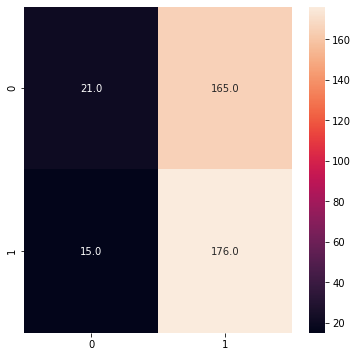

In [24]:
VCmodel = VotingClassifier(estimators=[('rf', RFmodel), ('xgb', XGBmodel), ('sgd', SGDmodel)], voting='hard', weights=[optimizer.max['params']['rf_w'],
                                                                                                    optimizer.max['params']['xgb_w'],
                                                                                                    optimizer.max['params']['sgd_w']])

VCmodel = VCmodel.fit(sentiment_x_train,sentiment_y_train)
sentiment_y_pred_vc = VCmodel.predict(sentiment_x_test)
np.savetxt(predicted_sentiment_impact_filename, sentiment_y_pred_vc, delimiter=',', fmt='%i')

get_model_evaluate(VCmodel, sentiment_x_train, sentiment_x_test, sentiment_y_train, sentiment_y_test, sentiment_y_pred_vc)

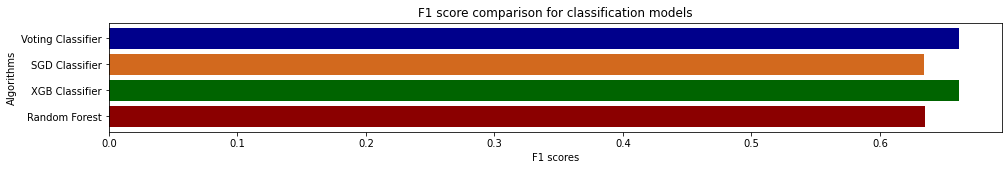

In [42]:
# F1 score comparison
f1_scores={}
f1_scores['Random Forest']=f1_score(sentiment_y_test, sentiment_y_pred_rf)
f1_scores['XGB Classifier']=f1_score(sentiment_y_test, sentiment_y_pred_xgb)
f1_scores['SGD Classifier']=f1_score(sentiment_y_test, sentiment_y_pred_sgd)
f1_scores['Voting Classifier']=f1_score(sentiment_y_test, sentiment_y_pred_vc)

plt.figure(figsize=(16,2))
plt.title("F1 score comparison for classification models")
plt.xlabel("F1 scores")
plt.ylabel("Algorithms")
plt.barh(list(f1_scores.keys()), f1_scores.values(), align='center', color=['darkred','darkgreen','chocolate','darkblue'])
plt.show()

#Stock Market Prediction

##Data Preprocessing

In [26]:
# Data Preprocessing
djia_data = pd.read_csv(stock_market_macro_filename)

# Drop extra fields
djia_data = djia_data.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)

In [27]:
# check if data is null
djia_data.isnull().sum()

Date              0
Adj Close         0
Wildfire          0
Hurricane         0
Flood             0
Blizzard          0
Snowstorm         0
Tornado           0
Covid             0
Season            0
Inflation Rate    0
dtype: int64

In [28]:
# Preserve float data type

djia_data['Adj Close']=np.asarray(djia_data['Adj Close']).astype(np.float32)
djia_data['Inflation Rate']=np.asarray(djia_data['Inflation Rate']).astype(np.float32)

## Exploratory Data Analysis

In [29]:
# Checking the shape of the data

print("shape of dataset :",djia_data.shape)
print("Data types of each column in dataset:\n", djia_data.dtypes)
print("\n\nSnapshot of dataset:\n", djia_data.head())

shape of dataset : (1989, 11)
Data types of each column in dataset:
 Date               object
Adj Close         float32
Wildfire           object
Hurricane          object
Flood              object
Blizzard           object
Snowstorm          object
Tornado            object
Covid              object
Season             object
Inflation Rate    float32
dtype: object


Snapshot of dataset:
          Date     Adj Close Wildfire  ... Covid  Season Inflation Rate
0  2016-07-01  17949.369141       No  ...    No  Summer            0.8
1  2016-06-30  17929.990234       No  ...    No  Summer            1.0
2  2016-06-29  17694.679688       No  ...    No  Summer            1.0
3  2016-06-28  17409.720703       No  ...    No  Summer            1.0
4  2016-06-27  17140.240234       No  ...    No  Summer            1.0

[5 rows x 11 columns]


## Feature Engineering

In [30]:
# label encoding of natural disasters and pandemics

le = LabelEncoder()

natural_disasters = ["Wildfire", "Hurricane", "Flood", "Blizzard", "Snowstorm", "Tornado", "Covid"]

print("Split of label encoded data:")
for each_disaster in natural_disasters:
  # print(each_disaster)
  djia_data[each_disaster] = le.fit_transform(djia_data[each_disaster])
  print(djia_data[each_disaster].value_counts())

print("\n\nSnapshot of dataset:\n", djia_data.head())

Split of label encoded data:
0    1893
1      96
Name: Wildfire, dtype: int64
0    1981
1       8
Name: Hurricane, dtype: int64
0    1831
1     158
Name: Flood, dtype: int64
0    1971
1      18
Name: Blizzard, dtype: int64
0    1979
1      10
Name: Snowstorm, dtype: int64
0    1980
1       9
Name: Tornado, dtype: int64
0    1989
Name: Covid, dtype: int64


Snapshot of dataset:
          Date     Adj Close  Wildfire  ...  Covid  Season  Inflation Rate
0  2016-07-01  17949.369141         0  ...      0  Summer             0.8
1  2016-06-30  17929.990234         0  ...      0  Summer             1.0
2  2016-06-29  17694.679688         0  ...      0  Summer             1.0
3  2016-06-28  17409.720703         0  ...      0  Summer             1.0
4  2016-06-27  17140.240234         0  ...      0  Summer             1.0

[5 rows x 11 columns]


In [31]:
# One hot encoding season

djia_data = pd.get_dummies(djia_data, columns=['Season'])
# data_forFE = data1

print("Shape of dataset: ", djia_data.shape)
print("\n\nSnapshot of dataset:\n", djia_data.head())

Shape of dataset:  (1989, 14)


Snapshot of dataset:
          Date     Adj Close  ...  Season_Summer  Season_Winter
0  2016-07-01  17949.369141  ...              1              0
1  2016-06-30  17929.990234  ...              1              0
2  2016-06-29  17694.679688  ...              1              0
3  2016-06-28  17409.720703  ...              1              0
4  2016-06-27  17140.240234  ...              1              0

[5 rows x 14 columns]


In [32]:
# Split into test and train

pd.options.mode.chained_assignment = None

djia_train = djia_data[(djia_data['Date'] < '2015-01-01')]
djia_test = djia_data[(djia_data['Date'] > '2014-12-31')]
djia_test = djia_test.iloc[1:]

#  adding in sentiment impact train  dataset and predictions
djia_train['Sentiment Impact'] = sentiment_y_train
djia_test['Sentiment Impact'] = sentiment_y_pred_vc

print("Shape of djia_train :", djia_train.shape)
print("Shape of djia_test :", djia_test.shape)

Shape of djia_train : (1611, 15)
Shape of djia_test : (377, 15)


In [33]:
# Sort by date

djia_train = djia_train.sort_values(by='Date',ascending=True)
djia_test = djia_test.sort_values(by='Date',ascending=True)

djia_train = djia_train.drop(['Date'], axis=1)
djia_test = djia_test.drop(['Date'], axis=1)

In [34]:
# Data normalization

scaler = MinMaxScaler(feature_range=(0, 1))
djia_train['Adj Close'] = scaler.fit_transform(djia_train['Adj Close'].values.reshape(-1, 1))
djia_test['Adj Close'] = scaler.transform(djia_test['Adj Close'].values.reshape(-1, 1))

In [35]:
# Prepare train dataset

WINDOW_SIZE = 70
FUTURE_STEPS = 1

djia_x_train = []
djia_y_train = [] 

# populate X_train with 60 previous stock prices 
# populate y_train with the next stock price
for i in range(WINDOW_SIZE, djia_train.shape[0]):
    
    djia_x_train.append(djia_train.iloc[i-WINDOW_SIZE:i, :]) 
    # hence we get the stock prices from day 0 to day 59 (prev 60). Output y_train will have the stock price of day 60, as the RNN will learn to predict. 
    # djia_y_train.append(djia_train.iloc[i+FUTURE_STEPS, 0])
    djia_y_train.append(djia_train.iloc[i+FUTURE_STEPS-1,0])
    # X_train and y_train are list..so we have to convert them in numpy array 

djia_x_train, djia_y_train = np.array(djia_x_train), np.array(djia_y_train)

print("Shape of x train: ", djia_x_train.shape)
print("Shape of y train: ", djia_y_train.shape)

Shape of x train:  (1541, 70, 14)
Shape of y train:  (1541,)


## Model Training

In [36]:
# Designing a stacked LSTM without dropout regularization

regressor = tf.keras.models.Sequential() # initializes the RNN
# adding layer 1 and dropout regularization 
# LSTM(<number of cells>, <return sequences = True ; as we are building a stacked model>, <input shape = shape of the input in X_train>)
regressor.add(tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (djia_x_train.shape[1],14) )) # we will add an object of LSTM class
regressor.add(tf.keras.layers.Dropout(0.2))
# adding new layers of LSTM with dropout regularization
regressor.add(tf.keras.layers.LSTM(units = 50, return_sequences = True)) # we will add an object of LSTM class
regressor.add(tf.keras.layers.Dropout(0.2))
regressor.add(tf.keras.layers.LSTM(units = 50, return_sequences = True)) # we will add an object of LSTM class
regressor.add(tf.keras.layers.Dropout(0.2))
regressor.add(tf.keras.layers.LSTM(units = 50, return_sequences = False)) # we will add an object of LSTM class
regressor.add(tf.keras.layers.Dropout(0.2))

# adding the output layer
# the output layer is fully connected to the output layer
regressor.add(tf.keras.layers.Dense(units = 1))
# compiling
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error') 
# training
regressor.fit(djia_x_train, djia_y_train, epochs = 100, batch_size = 32 )

Epoch 1/100
49/49 [==============================] - 10s 111ms/step - loss: 0.0906
Epoch 2/100
49/49 [==============================] - 6s 119ms/step - loss: 0.0067
Epoch 3/100
49/49 [==============================] - 6s 116ms/step - loss: 0.0057
Epoch 4/100
49/49 [==============================] - 6s 117ms/step - loss: 0.0043
Epoch 5/100
49/49 [==============================] - 6s 116ms/step - loss: 0.0055
Epoch 6/100
49/49 [==============================] - 6s 114ms/step - loss: 0.0032
Epoch 7/100
49/49 [==============================] - 6s 115ms/step - loss: 0.0035
Epoch 8/100
49/49 [==============================] - 6s 117ms/step - loss: 0.0043
Epoch 9/100
49/49 [==============================] - 6s 120ms/step - loss: 0.0032
Epoch 10/100
49/49 [==============================] - 6s 118ms/step - loss: 0.0029
Epoch 11/100
49/49 [==============================] - 6s 116ms/step - loss: 0.0035
Epoch 12/100
49/49 [==============================] - 6s 116ms/step - loss: 0.0033
Epoch 13/100

In [37]:
# Save model

model_json = regressor.to_json()

with open(model_path, "w") as json_file:
    json_file.write(model_json)
regressor.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## Model Testing

In [38]:
# get model

json_file = open(model_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
loaded_model.compile(loss='mean_squared_error', optimizer='adam')

Loaded model from disk


In [39]:
# test set

djia_x_test = []
djia_y_test = [] 

for i in range(WINDOW_SIZE, djia_test.shape[0]):
    djia_x_test.append(djia_test.iloc[i-WINDOW_SIZE:i, :]) 
    djia_y_test.append(djia_test.iloc[i+FUTURE_STEPS-1, 0])
djia_x_test, djia_y_test = np.array(djia_x_test), np.array(djia_y_test)

djia_x_test = np.reshape(djia_x_test, (djia_x_test.shape[0], djia_x_test.shape[1], 14))
djia_y_pred = loaded_model.predict(djia_x_test)

In [40]:
# inverse the scaling on the prediction and real stock price
real_stock_price = scaler.inverse_transform(djia_y_test.reshape(-1,1))
predicted_stock_price = scaler.inverse_transform(djia_y_pred)

print("Mean Absoluete Error: ", mean_absolute_error(real_stock_price, predicted_stock_price))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price)))

Mean Absoluete Error:  443.68597
Root Mean Squared Error:  600.63306


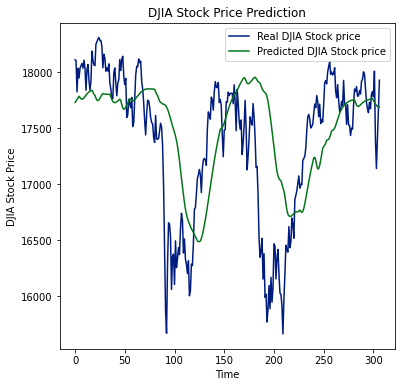

In [41]:
# visualizing the result

fig = plt.figure()
plt.plot(real_stock_price, label = 'Real DJIA Stock price')
plt.plot(predicted_stock_price, label = 'Predicted DJIA Stock price')
plt.title('DJIA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('DJIA Stock Price')
plt.legend()
plt.show()
fig.savefig(stock_prediction_plot_path, dpi=fig.dpi)